In [1]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [3]:
import pandas as pd

df = pd.read_json("https://raw.githubusercontent.com/codebasics/nlp-tutorials/main/14_word_vectors_spacy_text_classification/news_dataset.json")

In [4]:
df

,text,category
0,"Larry Nassar Blames His Victims, Says He 'Was ...",CRIME
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME
2,Vegas Taxpayers Could Spend A Record $750 Mill...,SPORTS
3,This Richard Sherman Interception Literally Sh...,SPORTS
4,7 Things That Could Totally Kill Weed Legaliza...,BUSINESS
...,...,...
7495,Sex Offender Registries Are Not Really Keeping...,CRIME
7496,'Stockbroker's Bible' Just Told Oil Industry T...,BUSINESS
7497,Want to Change It? Scale It!,BUSINESS
7498,"How To Make A Billion Dollar Drug In 1961, new...",BUSINESS


In [5]:
df['category'].value_counts()

CRIME       2500
SPORTS      2500
BUSINESS    2500
Name: category, dtype: int64

In [6]:
df['label'] = df['category'].map({'CRIME':0,'SPORTS':1,'BUSINESS':2})

In [7]:
df

,text,category,label
0,"Larry Nassar Blames His Victims, Says He 'Was ...",CRIME,0
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME,0
2,Vegas Taxpayers Could Spend A Record $750 Mill...,SPORTS,1
3,This Richard Sherman Interception Literally Sh...,SPORTS,1
4,7 Things That Could Totally Kill Weed Legaliza...,BUSINESS,2
...,...,...,...
7495,Sex Offender Registries Are Not Really Keeping...,CRIME,0
7496,'Stockbroker's Bible' Just Told Oil Industry T...,BUSINESS,2
7497,Want to Change It? Scale It!,BUSINESS,2
7498,"How To Make A Billion Dollar Drug In 1961, new...",BUSINESS,2


In [12]:
def preprocess_text(text):
    doc = nlp(text)
    filtered_tokens = []
    
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    
    return " ".join(filtered_tokens)

In [13]:
preprocess_text(df['text'][1])

'woman Beats Cancer die fall horse'

In [14]:
df['preprocessed_text'] = df['text'].apply(lambda text: preprocess_text(text))

In [16]:
df.head()

,text,category,label,preprocessed_text
0,"Larry Nassar Blames His Victims, Says He 'Was ...",CRIME,0,Larry Nassar blame victim say victimize newly ...
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME,0,woman Beats Cancer die fall horse
2,Vegas Taxpayers Could Spend A Record $750 Mill...,SPORTS,1,vegas taxpayer spend Record $ 750 million New ...
3,This Richard Sherman Interception Literally Sh...,SPORTS,1,Richard Sherman Interception literally shake W...
4,7 Things That Could Totally Kill Weed Legaliza...,BUSINESS,2,7 thing totally kill Weed Legalization Buzz


In [17]:
df['vector'] = df['preprocessed_text'].apply(lambda txt: nlp(txt).vector)

In [18]:
df.head()

,text,category,label,preprocessed_text,vector
0,"Larry Nassar Blames His Victims, Says He 'Was ...",CRIME,0,Larry Nassar blame victim say victimize newly ...,"[-0.5585511, -0.29323253, -0.9253956, 0.189389..."
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME,0,woman Beats Cancer die fall horse,"[-0.73039824, -0.43196002, -1.2930516, -1.0628..."
2,Vegas Taxpayers Could Spend A Record $750 Mill...,SPORTS,1,vegas taxpayer spend Record $ 750 million New ...,"[-1.9413117, 0.121578515, -3.2996283, 1.511650..."
3,This Richard Sherman Interception Literally Sh...,SPORTS,1,Richard Sherman Interception literally shake W...,"[-1.4702771, -0.685319, 0.57398, -0.31135806, ..."
4,7 Things That Could Totally Kill Weed Legaliza...,BUSINESS,2,7 thing totally kill Weed Legalization Buzz,"[-1.037173, -1.9495698, -1.7179357, 1.2975286,..."


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['vector'].values,
    df['label'],
    test_size=0.2,
    random_state=2022,
    stratify=df.label
)

In [21]:
import numpy as np

print("X_train : ",X_train.shape)
print("X_test : ",X_test.shape)

X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

print("X_train : ",X_train_2d.shape)
print("X_test : ",X_test_2d.shape)


X_train :  (6000,)
X_test :  (1500,)
X_train :  (6000, 300)
X_test :  (1500, 300)


In [22]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier()

dt_clf.fit(X_train_2d,y_train)

DecisionTreeClassifier()

In [23]:
y_dt = dt_clf.predict(X_test_2d)

In [28]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_dt))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73       500
           1       0.71      0.73      0.72       500
           2       0.74      0.72      0.73       500

    accuracy                           0.73      1500
   macro avg       0.73      0.73      0.73      1500
weighted avg       0.73      0.73      0.73      1500



In [29]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train_2d)
X_test_scaled = scaler.transform(X_test_2d)

mn_clf = MultinomialNB()

mn_clf.fit(X_train_scaled,y_train)

y_mn = mn_clf.predict(X_test_scaled)

print(classification_report(y_test,y_mn))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       500
           1       0.85      0.77      0.81       500
           2       0.80      0.83      0.82       500

    accuracy                           0.83      1500
   macro avg       0.83      0.83      0.83      1500
weighted avg       0.83      0.83      0.83      1500



In [30]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=5, metric='euclidean')

knn_clf.fit(X_train_2d,y_train)

y_knn = knn_clf.predict(X_test_2d)

print(classification_report(y_test,y_knn))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88       500
           1       0.92      0.81      0.86       500
           2       0.88      0.87      0.88       500

    accuracy                           0.87      1500
   macro avg       0.88      0.87      0.87      1500
weighted avg       0.88      0.87      0.87      1500



In [31]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

rf_clf.fit(X_train_2d,y_train)

y_rf = rf_clf.predict(X_test_2d)

print(classification_report(y_test,y_rf))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       500
           1       0.90      0.84      0.87       500
           2       0.86      0.88      0.87       500

    accuracy                           0.88      1500
   macro avg       0.88      0.88      0.88      1500
weighted avg       0.88      0.88      0.88      1500



In [32]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier()

gb_clf.fit(X_train_2d,y_train)

y_gb = gb_clf.predict(X_test_2d)

print(classification_report(y_test,y_gb))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       500
           1       0.91      0.87      0.89       500
           2       0.88      0.92      0.90       500

    accuracy                           0.90      1500
   macro avg       0.90      0.90      0.90      1500
weighted avg       0.90      0.90      0.90      1500



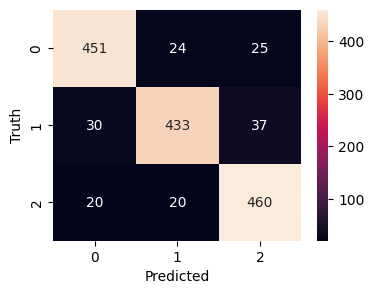

In [33]:
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,y_gb)
plt.figure(figsize=(4,3))
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.show()